In [82]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
# from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
# import pyro.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

## Read Data

In [83]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [84]:
data = pd.read_csv('data/agg_data.csv')

In [85]:
data.columns

Index(['month', 'CensusTract', 'FELONY', 'MISDEMEANOR', 'VIOLATION',
       'TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap'],
      dtype='object')

In [86]:
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)

In [87]:
data['target'] = data['target'].astype(int)

In [88]:
def get_data(data, features, target):
    df_X = data[features]
    df_y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)

    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)

    population =  torch.from_numpy(np.array(X_train['TotalPop'])).type(torch.float32)

    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)

    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)

    test_population =  torch.from_numpy(np.array(X_test['TotalPop'])).type(torch.float32)
    return X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population


In [89]:
def plot_hist(x, y, num_bins):
    n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='blue', alpha=0.5)

    # add a 'best fit' line
    plt.plot(bins, y, 'r--')
    plt.xlabel('Smarts')
    plt.ylabel('Probability')
    plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)
    plt.show()

## Feature Vizualizing

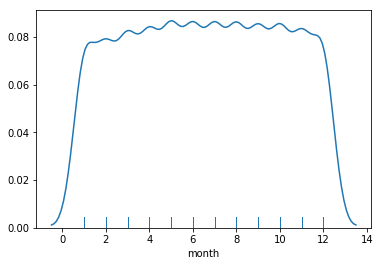

In [90]:
sns.distplot(data['month'], hist=False, rug=True);


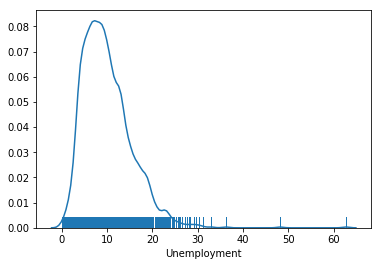

In [91]:
sns.distplot(data['Unemployment'], hist=False, rug=True);


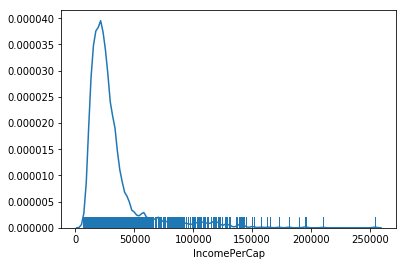

In [92]:
sns.distplot(data['IncomePerCap'], hist=False, rug=True);


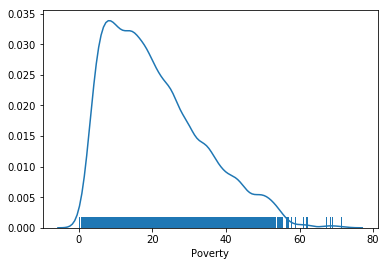

In [93]:
sns.distplot(data['Poverty'], hist=False, rug=True);


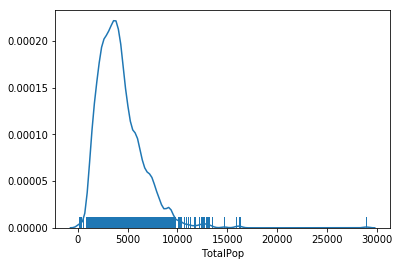

In [94]:
sns.distplot(data['TotalPop'], hist=False, rug=True);


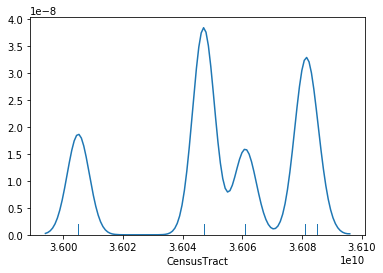

In [95]:
sns.distplot(data['CensusTract'], hist=False, rug=True);


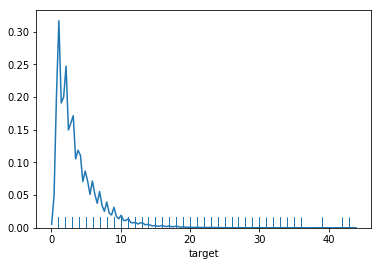

In [96]:
sns.distplot(data['target'], hist=False, rug=True);


In [97]:
data['target'].median()

3.0

In [98]:
len(data[data['target']>2])

11181

In [99]:
len(data[data['target']<=2])

9391

In [100]:
bool_split = 2

In [101]:
high_risk_area = [1 if t>2 else 0 for t in list(data['target'])]

In [102]:
data['binary_target'] = high_risk_area

In [103]:
data['binary_target']

0        0
1        1
2        0
3        1
4        1
        ..
20567    1
20568    1
20569    1
20570    1
20571    0
Name: binary_target, Length: 20572, dtype: int64

## Model 1

In [32]:
features = ['month', 'CensusTract','TotalPop', 'Poverty', 'Unemployment', 'IncomePerCap']
target = 'binary_target'
X_nuts_train, y_nuts_train, population, X_nuts_test, y_nuts_test, test_population = get_data(data, features, target)

In [33]:
y_nuts_train

tensor([1., 0., 1.,  ..., 1., 1., 1.])

In [35]:
def model(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
            
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    

In [38]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train,X_nuts_train.numpy().shape[1])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


sample: 100%|██████████| 1200/1200 [00:18<00:00, 65.93it/s, step size=7.31e-03, acc. prob=0.900]


In [39]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [40]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta0
       mean       std        5%      25%       50%       75%       95%
0  0.000008  0.000099 -0.000156 -0.00006  0.000009  0.000074  0.000171 

Site: beta1
       mean     std        5%       25%       50%       75%       95%
0 -0.000004  0.0001 -0.000174 -0.000071 -0.000003  0.000066  0.000161 

Site: beta2
       mean       std        5%       25%           50%       75%       95%
0  0.000003  0.000102 -0.000171 -0.000065  6.986447e-07  0.000069  0.000178 

Site: beta3
       mean       std       5%       25%       50%       75%       95%
0 -0.000005  0.000099 -0.00016 -0.000074 -0.000009  0.000061  0.000166 

Site: beta4
       mean       std        5%       25%           50%       75%      95%
0  0.000003  0.000101 -0.000159 -0.000068 -7.210717e-07  0.000075  0.00017 

Site: beta5
       mean       std        5%       25%       50%       75%       95%
0  0.000002  0.000102 -0.000163 -0.000067  0.000001  0.000072  0.000167 

Site: beta6
           mean       std        5

In [41]:
sites = list(hmc_samples.keys())
sites

['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6']

beta0
beta1
beta2
beta3
beta4
beta5
beta6


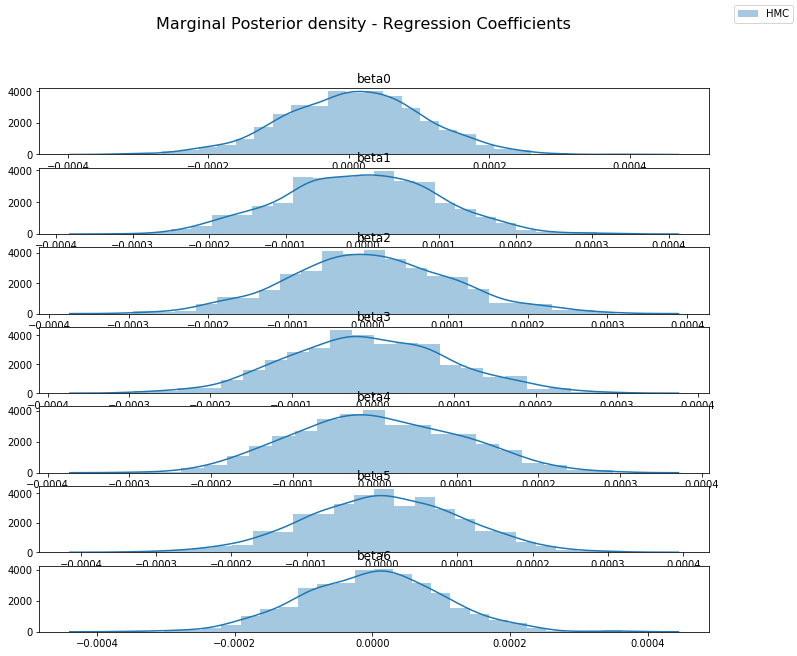

In [43]:
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [44]:
mean_hmc_samples = {}
for k,v in hmc_samples.items():
    mean_hmc_samples[k] = np.mean(hmc_samples[k])

In [45]:
def predict(X_nuts_test, test_population, mean_hmc_samples):
    output = mean_hmc_samples['beta0']
    for i in range(X_nuts_test.shape[1]):
        output += mean_hmc_samples['beta{}'.format(i+1)]*X_nuts_test[:,i]
    p = 1. / (1 + torch.exp(-output))
    yield dist.Bernoulli(p).sample()
    

In [46]:
results = torch.stack(list(predict(X_nuts_test, test_population, mean_hmc_samples)))


In [47]:
y_pred = results.numpy()[0].transpose()
acc_model_1 = accuracy_score(y_pred, y_nuts_test)

In [48]:
acc_model_1

0.5071688942891859

In [49]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.], dtype=float32)

In [50]:
y_nuts_test

tensor([1., 1., 1.,  ..., 0., 0., 0.])

## Model 2: Improving model 1, incorporating unstructured spatial R.V 

In [104]:
def model(data_x, data_y, D):
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    

In [105]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc_run = mcmc.run(X_nuts_train, y_nuts_train,X_nuts_train.numpy().shape[1])

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


sample: 100%|██████████| 1200/1200 [09:41<00:00,  2.07it/s, step size=7.25e-03, acc. prob=0.902]


In [106]:

# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [107]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: beta0
           mean       std        5%       25%       50%       75%       95%
0 -3.115552e-08  0.000099 -0.000159 -0.000065 -0.000003  0.000069  0.000159 

Site: beta1
       mean     std        5%       25%           50%      75%       95%
0  0.000002  0.0001 -0.000156 -0.000068 -4.813965e-07  0.00007  0.000167 

Site: beta2
       mean       std        5%       25%       50%       75%       95%
0  0.000003  0.000101 -0.000152 -0.000066  0.000004  0.000071  0.000161 

Site: beta3
       mean       std        5%       25%           50%      75%       95%
0 -0.000002  0.000098 -0.000162 -0.000061 -1.928292e-07  0.00006  0.000159 

Site: beta4
       mean     std        5%       25%       50%       75%      95%
0 -0.000002  0.0001 -0.000166 -0.000067 -0.000002  0.000065  0.00016 

Site: beta5
       mean       std        5%       25%       50%       75%       95%
0  0.000003  0.000096 -0.000151 -0.000061  0.000002  0.000067  0.000162 

Site: beta6
           mean       std     

In [108]:
sites = list(hmc_samples.keys())
sites

['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6', 'sd_u', 'u_i']

beta0
beta1
beta2
beta3
beta4
beta5
beta6
sd_u
u_i


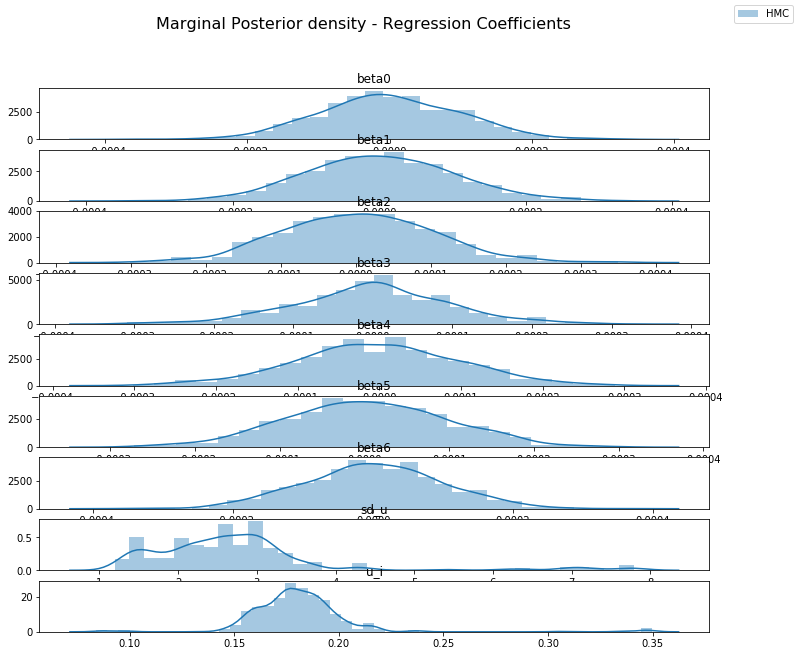

In [114]:
fig, axs = plt.subplots(nrows=9, ncols=1, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    print(site)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")        
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [112]:
def predict(X_nuts_test, test_population, mean_hmc_samples):
    output = mean_hmc_samples['beta0']
    for i in range(X_nuts_test.numpy().shape[1]):
        output += mean_hmc_samples['beta{}'.format(i+1)]*X_nuts_test[:,i]
    output += mean_hmc_samples['sd_u']
    p = 1. / (1 + torch.exp(-output))
    yield dist.Bernoulli(p).sample()
    

In [113]:
results = torch.stack(list(predict(X_nuts_test, test_population, mean_hmc_samples)))

y_pred = results.numpy()[0].transpose()
acc_model_2 = accuracy_score(y_pred, y_nuts_test)

KeyError: 'u_i'

## Model 3: Improving model 2, incorporating the space related terms

In [59]:
data['CensusTract']

0        36005000200
1        36005000400
2        36005001600
3        36005001900
4        36005002000
            ...     
20567    36085030301
20568    36085030302
20569    36085031901
20570    36085031902
20571    36085032300
Name: CensusTract, Length: 20572, dtype: int64

warmup:   6%|▌         | 67/1200 [00:21<02:49,  6.70it/s, step size=8.11e-05, acc. prob=0.781]

## Building the Conditional Auto Regressor Module

In [60]:
census_ids = {}
i = 0
for ct in data['CensusTract']:
    if ct not in census_ids:
        census_ids[ct] = i
        i += 1

In [64]:
data['CensusIds'] = [census_ids[c] for c in data['CensusTract']]

In [66]:
len(census_ids)

2092

In [77]:
W = np.ones((len(census_ids), len(census_ids))) #Should be neighbourhood matrix instead

In [79]:
W_star = W/(np.sum(W, axis=0) + 1)

In [81]:
s_i = np.sum(W_star, axis=0)

In [ ]:
#complete Car model

In [ ]:
def model(data_x, data_y, D):
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 0.0001)))
        
    sd_u = pyro.sample("sd_u",dist.Uniform(0,100))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit)) 
    
#     s_i = 
    

    with pyro.plate("data", len(data_y)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    